
# Mini GPT Language Model (PyTorch)

This notebook implements a transformer-based character-level language model from scratch using PyTorch. It includes components such as multi-head self-attention, feedforward networks, and positional embeddings.


In [2]:

import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

torch.manual_seed(1337)



## Dataset Preparation

We load the text dataset (`miniSpeare.txt`) and create character-to-index mappings. The text is tokenized into integers for model consumption.


In [3]:

with open('miniSpeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


## Batch Sampling Function

In [4]:

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


## Loss Estimation Utility

In [5]:

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


## Attention Mechanism: Single Head

In [6]:

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out


## Multi-Head Attention Layer

In [7]:

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


## Feedforward Layer

In [8]:

class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


## Transformer Block

In [9]:

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


## Full GPT Model Definition

In [10]:

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


## Model Initialization and Training

In [16]:
import time

# GPU info
if device == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1e6:.2f} MB")
    print(f"Memory Cached:    {torch.cuda.memory_reserved(0)/1e6:.2f} MB")

model = GPTLanguageModel().to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# List to store logs
step_logs = []
train_loss_log = []
val_loss_log = []
gpu_memory_log = []
eval_points = []

# Training loop
for iter in range(max_iters):
    start_time = time.time()

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_loss_log.append(losses['train'])
        val_loss_log.append(losses['val'])
        eval_points.append(iter)
        step_logs.append(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    elapsed_time = time.time() - start_time
    if device == 'cuda':
        gpu_memory_log.append(torch.cuda.memory_allocated(0) / 1e6)
    step_logs.append(f"Step {iter} completed in {elapsed_time:.3f} seconds.")

# Print all logs together
print("\n=== Training Summary ===")
for log in step_logs:
    print(log)


Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memory Allocated: 86.35 MB
Memory Cached:    492.83 MB
10.788929 M parameters

=== Training Summary ===
step 0: train loss 4.3803, val loss 4.3759
Step 0 completed in 44.322 seconds.
Step 1 completed in 0.330 seconds.
Step 2 completed in 0.363 seconds.
Step 3 completed in 0.368 seconds.
Step 4 completed in 0.354 seconds.
Step 5 completed in 0.344 seconds.
Step 6 completed in 0.359 seconds.
Step 7 completed in 0.360 seconds.
Step 8 completed in 0.357 seconds.
Step 9 completed in 0.346 seconds.
Step 10 completed in 0.351 seconds.
Step 11 completed in 0.349 seconds.
Step 12 completed in 0.349 seconds.
Step 13 completed in 0.348 seconds.
Step 14 completed in 0.350 seconds.
Step 15 completed in 0.349 seconds.
Step 16 completed in 0.349 seconds.
Step 17 completed in 0.350 seconds.
Step 18 completed in 0.348 seconds.
Step 19 completed in 0.349 seconds.
Step 20 completed in 0.339 seconds.
Step 21 completed in 0.356 seconds.
Step 22 completed in 0.3

## Loss Curve, Perplexity Curve, GPU Memory Usage Time curve

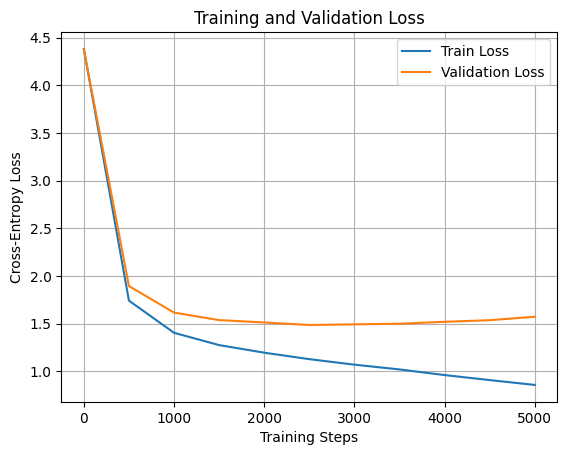

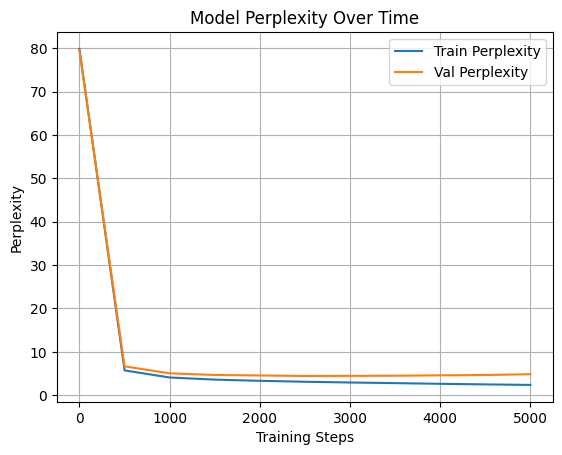

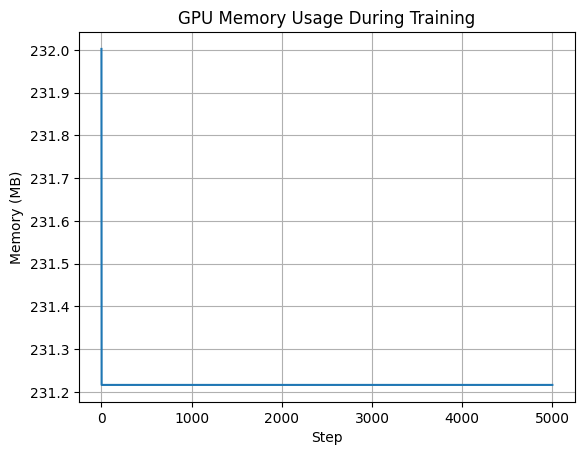

In [17]:
import matplotlib.pyplot as plt

plt.plot(eval_points, train_loss_log, label='Train Loss')
plt.plot(eval_points, val_loss_log, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

import numpy as np

plt.plot(eval_points, np.exp(train_loss_log), label='Train Perplexity')
plt.plot(eval_points, np.exp(val_loss_log), label='Val Perplexity')
plt.xlabel('Training Steps')
plt.ylabel('Perplexity')
plt.title('Model Perplexity Over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(gpu_memory_log)
plt.title('GPU Memory Usage During Training')
plt.xlabel('Step')
plt.ylabel('Memory (MB)')
plt.grid(True)
plt.show()


## Text Generation

In [18]:
# Generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


You have looks of this brother! he hate us faint
As it was you spit to his very advices,
The assault'st under of that is commissite
You made, strange away, for my cousin
My brother. Shall I rendeem for that;
If never were your tendered brothers.

LEONTES:
Why, speak your breasts?

First Senator:
Your petitodile: speak, Beseecing.

COMINIUS:
Afected; and so, peace praciously
Upatrimes; where's they detecting to common them.
Or silenting: with some day of Vity,
Thou take'st offen to begin to wear 


In [19]:
# Empty cache and collect garbage
import gc

del model
gc.collect()
torch.cuda.empty_cache()

# Check GPU memory after training
if device == 'cuda':
    print(f"Final GPU memory allocated: {torch.cuda.memory_allocated(0)/1e6:.2f} MB")
    print(f"Final GPU memory reserved:  {torch.cuda.memory_reserved(0)/1e6:.2f} MB")


Final GPU memory allocated: 202.05 MB
Final GPU memory reserved:  570.43 MB
